<a href="https://colab.research.google.com/github/Harshcs2002/LGMVIP-DataScience/blob/main/More%20Advanced%20Level%20Task/Task10/LGMVIPTask10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LetsGrowMore (LGMVIP) - "DATA SCIENCE INTERN"
# LGMVIP June-23

# AUTHOR - HARSH JAISWAL

## More Advanced Level Task

## TASK-10- : ML Facial recognition to detect mood and suggest songs accordingly

# Loading the dataset
### Dataset link : https://www.kaggle.com/msambare/fer2013

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download msambare/fer2013

 96% 58.0M/60.3M [00:00<00:00, 135MB/s] 
100% 60.3M/60.3M [00:00<00:00, 113MB/s]


In [8]:
! unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [9]:
! pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing Libraries

In [10]:
#Import Libraries/Packages
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [33]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.12.0
Num GPUs Available:  1


### Data Visualization

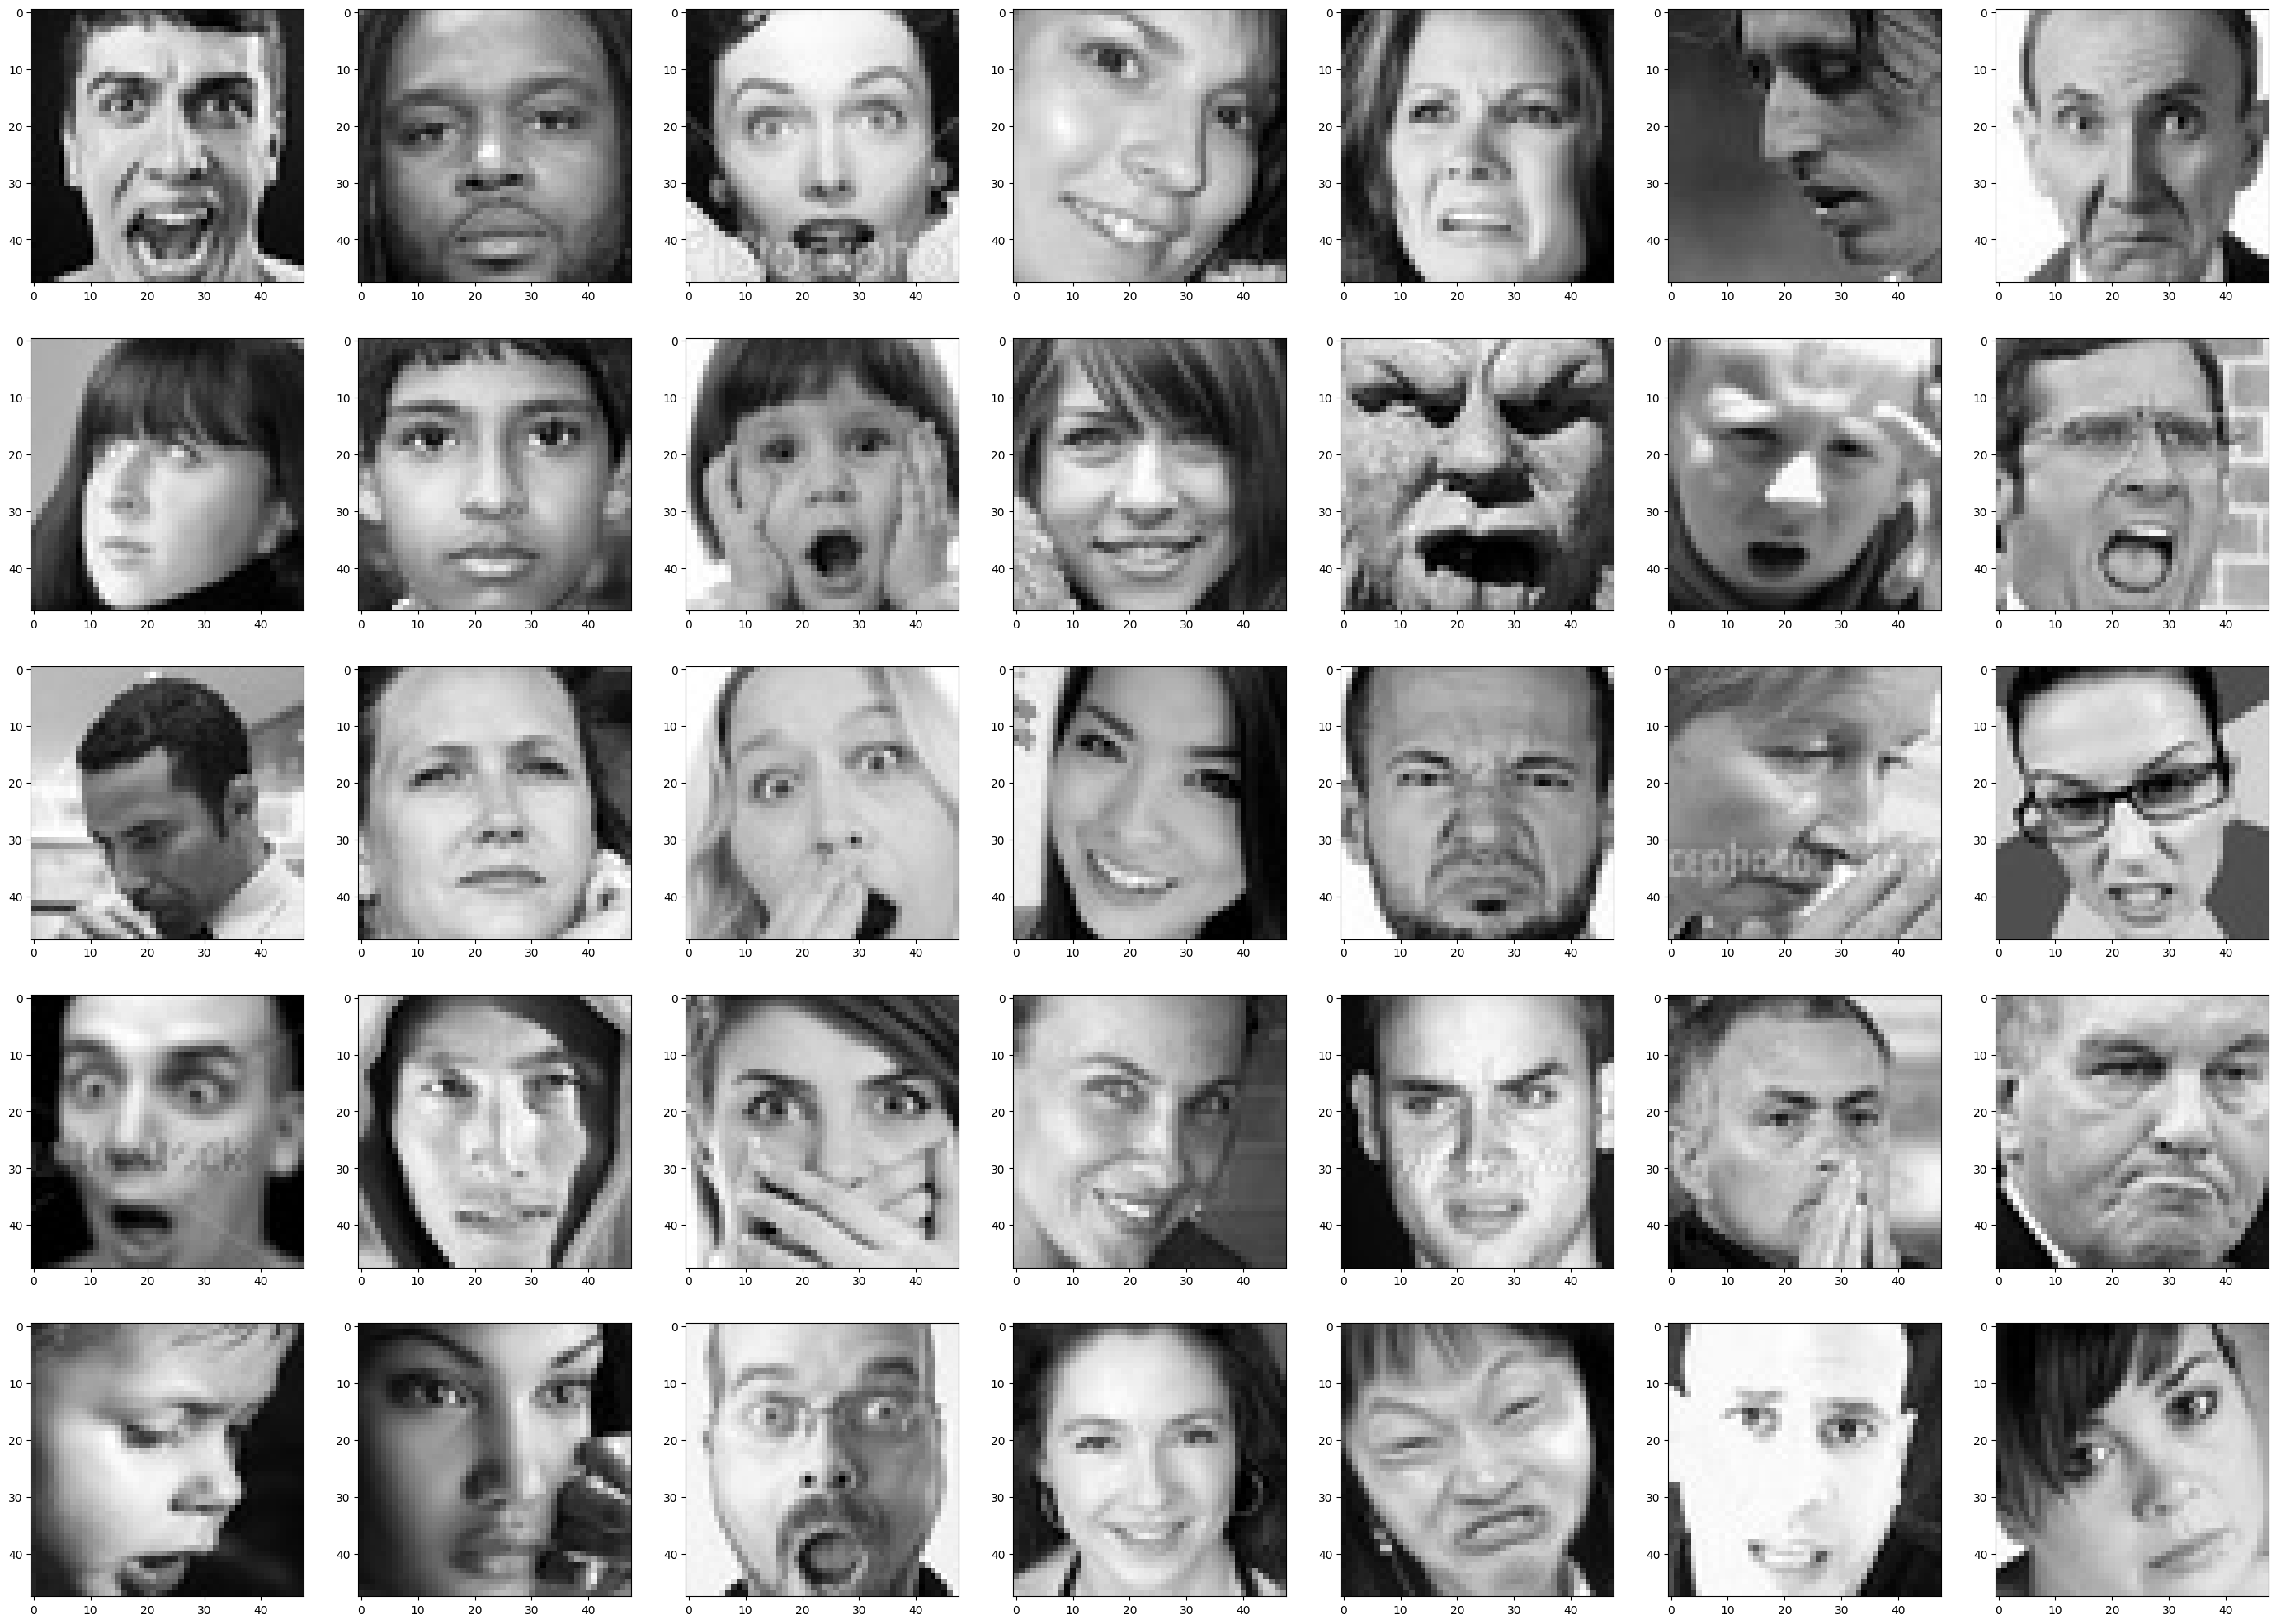

In [34]:
# Data Visualization
from skimage.io import imread
train_dir = "/content/train/"
test_dir = "/content/test/"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

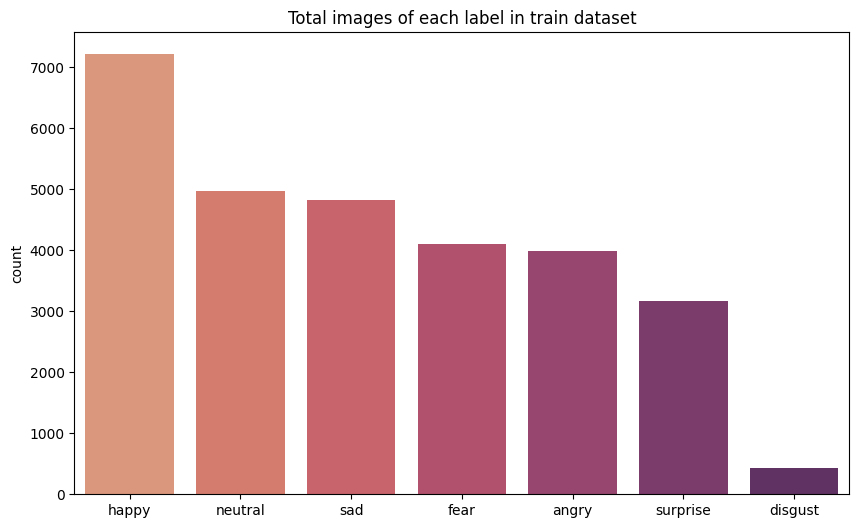

In [35]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="flare", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

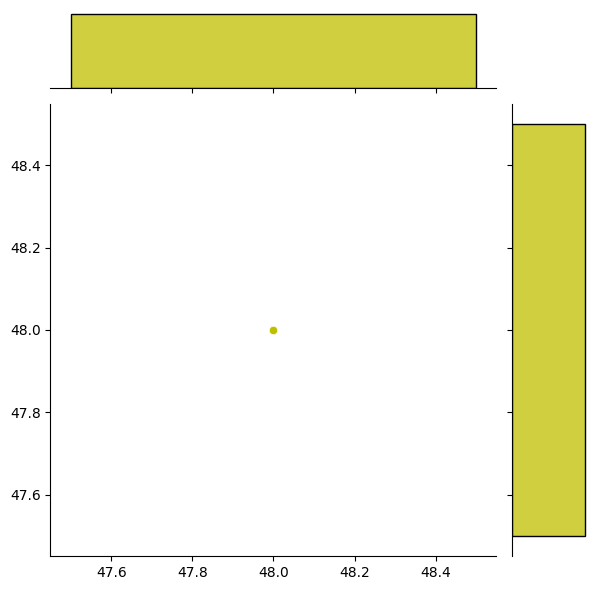

In [36]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(x=dim1, y=dim2,color='y')
plt.show()

In [37]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Creating the Model

In [38]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_5 (Batc  (None, 24, 24, 128)     

### Training the model

In [39]:
# Train the model
epochs = 25
learning_rate = 0.0001
decay_rate = learning_rate / epochs
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate, decay=decay_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [40]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 25

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/25
448/448 [==============================] - 34s 73ms/step - loss: 1.8738 - accuracy: 0.2285 - val_loss: 2.2585 - val_accuracy: 0.1816
Epoch 2/25
448/448 [==============================] - 35s 77ms/step - loss: 1.8014 - accuracy: 0.2455 - val_loss: 1.7675 - val_accuracy: 0.2808
Epoch 3/25
448/448 [==============================] - 36s 80ms/step - loss: 1.7887 - accuracy: 0.2558 - val_loss: 1.8184 - val_accuracy: 0.2684
Epoch 4/25
448/448 [==============================] - 43s 95ms/step - loss: 1.7722 - accuracy: 0.2631 - val_loss: 1.7744 - val_accuracy: 0.2871
Epoch 5/25
448/448 [==============================] - 32s 71ms/step - loss: 1.7573 - accuracy: 0.2755 - val_loss: 1.9413 - val_accuracy: 0.3001
Epoch 6/25
448/448 [==============================] - 31s 70ms/step - loss: 1.7391 - accuracy: 0.2884 - val_loss: 1.6512 - val_accuracy: 0.3429
Epoch 7/25
448/448 [==============================] - 31s 70ms/step - loss: 1.7087 - accuracy: 0.3075 - val_loss: 1.5832 - val_accuracy:

### Saving the trained model

In [41]:
model.save("model.h5")

### Evaluating the model

In [42]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 3s 28ms/step - loss: 1.2373 - accuracy: 0.5244
validation accuracy : 52.438002824783325%
validation loss : 1.2372592687606812


### Plotting Training and Validation plot

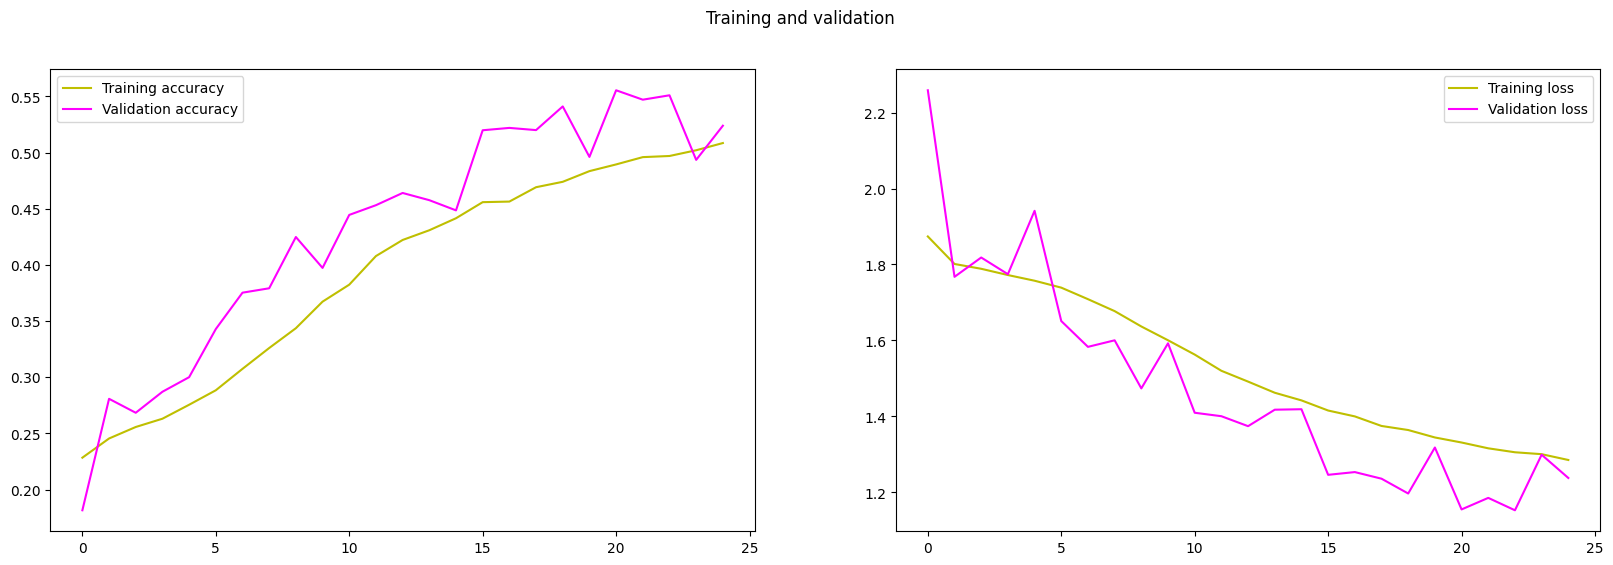

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'magenta', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'magenta', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

### Plotting the confusion matrix

113/113 [==============================] - 4s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.42      0.46      0.44       958
     disgust       0.00      0.00      0.00       111
        fear       0.43      0.15      0.22      1024
       happy       0.68      0.86      0.76      1774
     neutral       0.40      0.69      0.51      1233
         sad       0.44      0.15      0.23      1247
    surprise       0.60      0.72      0.65       831

    accuracy                           0.52      7178
   macro avg       0.42      0.43      0.40      7178
weighted avg       0.50      0.52      0.48      7178





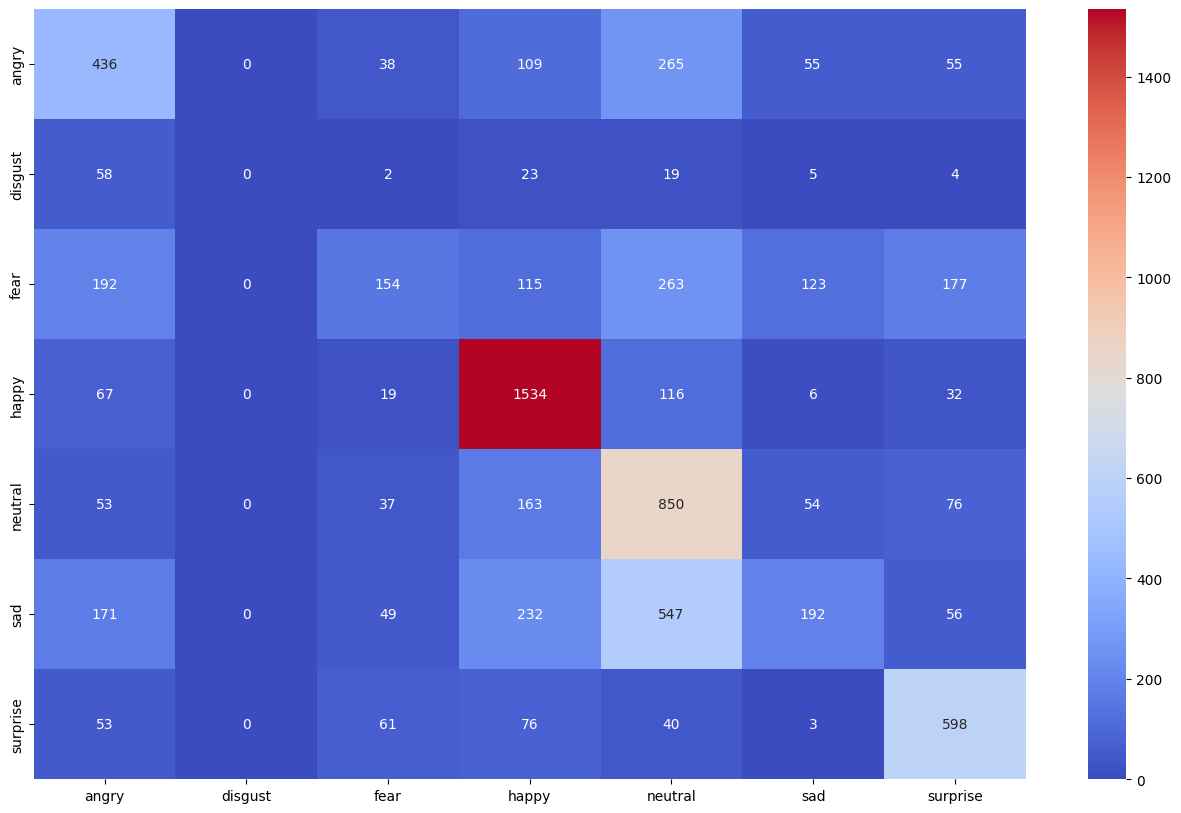

In [44]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.coolwarm, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

### Testing our model with new images

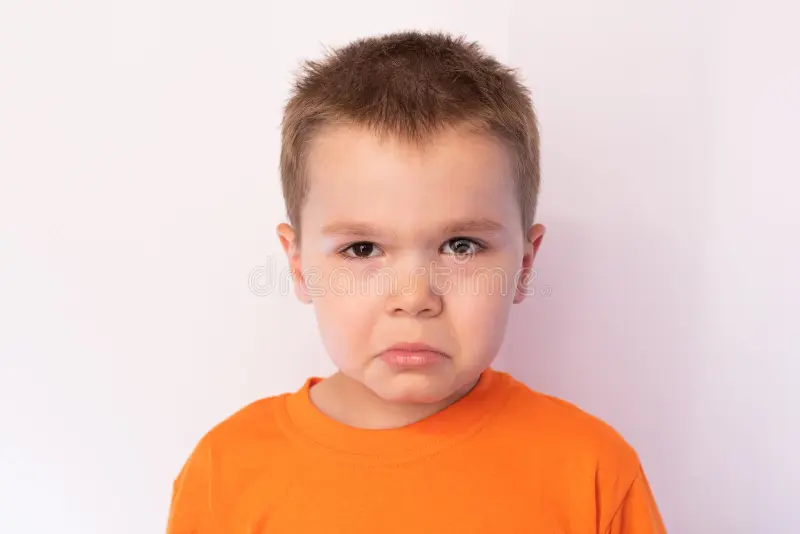

In [65]:
# Testing our model with new images
image1 = cv2.imread("/content/sadimg.jpg")
image2 = cv2.imread("/content/happy.jpg")
from IPython.display import Image
Image(filename='/content/sadimg.jpg')

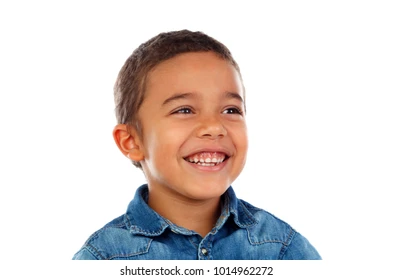

In [66]:
Image(filename='/content/happy.jpg')

### Model prediction and Song Recommdation 

In [62]:
import cv2
from tensorflow.python.keras.models import load_model
import os


def predict_emotion(image):
    # Load the trained model
    model = load_model("/content/model.h5", custom_objects={'BatchNormalization': tf.keras.layers.BatchNormalization})
    # A list of emoticon categories
    EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Neutral', 'Surprise']
    
    # Trim the image to 48 x 48, convert it to grayscale, and normalize
    frame = cv2.resize(image, (48, 48), interpolation=cv2.INTER_BITS2)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

    # Reshape the image dimension
    gray = gray.reshape(1, 48, 48, 1)

    # Perform the prediction
    predicts = model.predict(gray)[0]
    label = EMOTIONS[predicts.argmax()]
    
    print(f'This person looks {label}!')
    print('I think it is what he needs now! Listen to one of these tracks:')
    
    link = 'http://inmood.ru/mood/'
    
    if label == 'Angry':
        print(f'{link}angry/ , for example "Violence — Dope"')
    elif label == 'Disgust':
        print(f'{link}rebel/ , for example "Metallica — Die Die My Darling"')
    elif label == 'Fear':
        print(f'{link}worried/ , for example "Lux Aeterna — Clint Mansell Feat. Krono"')
    elif label == 'Happy':
        print(f'{link}happy/ , for example "Safe And Sound — Capital Cities"')
    elif label == 'Sad':
        print(f'{link}sad/ , for example "Black Black Heart — David Usher"')
    elif label == 'Neutral':
        print(f'{link}calm/ , for example "Im Not The Only One — Sam Smith"')
    else:
        print(f'{link}positive/ , for example "I Got You (I Feel Good) — James Brown"')

In [67]:
predict_emotion(image1)

This person looks Sad!
I think it is what he needs now! Listen to one of these tracks:
http://inmood.ru/mood/sad/ , for example "Black Black Heart — David Usher"


In [68]:
predict_emotion(image2)

This person looks Happy!
I think it is what he needs now! Listen to one of these tracks:
http://inmood.ru/mood/happy/ , for example "Safe And Sound — Capital Cities"


# Thank You :)